# Channels covariance

In this notebook we compute the covariance between channels. The goal is to understand if physical correlations between channels and across time are maintained in the synthetic image.

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from torch.utils.data import DataLoader
import torch

from scipy.ndimage import uniform_filter, convolve
from scipy.stats import levene

from sdo.datasets.sdo_dataset import SDO_Dataset
from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset
from sdo.models.vt_models.vt_unet import VT_UnetGenerator
from sdo.metrics.covariance import time_covariance, cov_1d, neighbor_cov

In [3]:
results_path = '/fdl_sdo_data/bucket/EXPERIMENT_RESULTS/VIRTUAL_TELESCOPE/vale_exp_20/'
filename_211 = results_path + '0600_vale_exp_20_test_predictions_timestamps.npz'

In [4]:
def list_dates(pred_path):
    pred = np.load(pred_path)
    timestamps = pred['ts']
    return timestamps

def find_date_index(date, data):
    for index, item in enumerate(data['ts']):
        if all(item == date):
            return index
    print(f'The date {date} has not been found')
    return None
        
def load_timestamped_img(pred_path, dates, img='img'):
    pred = np.load(pred_path)
    indexes = [find_date_index(date, pred) for date in dates]
    if None not in indexes:
        return pred[img][indexes]
    else:
        print(f'None is not a valid index, img cannot be loaded')

def cov_channels_on_time(pred_path_ch1, pred_path_ch2, dates, img='img'):
    ch1_img = load_timestamped_img(pred_path_ch1, dates, img)
    ch2_img = load_timestamped_img(pred_path_ch2, dates, img)
    return time_covariance(ch1_img, ch2_img)

In [5]:
timestamps = list_dates(filename_211)

In [6]:
timestamps[:20]

array([[2011,    8,   23,   12,    0],
       [2012,    8,   19,   12,    0],
       [2012,    8,    9,   18,    0],
       [2011,    9,   30,   12,    0],
       [2011,    9,   14,   12,    0],
       [2011,    9,    5,   18,    0],
       [2012,   10,   23,   12,    0],
       [2011,    8,   16,   18,    0],
       [2011,    9,   22,    0,    0],
       [2012,    9,   28,    6,    0],
       [2011,   10,    2,   12,    0],
       [2012,    9,   15,    0,    0],
       [2011,    9,    9,   12,    0],
       [2012,    9,    7,   18,    0],
       [2011,    8,   11,    0,    0],
       [2012,    9,   14,    0,    0],
       [2011,    8,   27,   18,    0],
       [2011,   10,    9,    0,    0],
       [2011,    9,    1,   12,    0],
       [2012,    8,   15,    0,    0]])

In [7]:
# dates roughly one month apart
cov_dates = [[2012,   8,   26,   6,    0], 
             [2012,   9,   30,   18,    0], 
             [2012,   10,   30,   18,    0]]

## Auto-correlation on 211 - average across time

In [8]:
pred_cov = cov_channels_on_time(filename_211, filename_211, cov_dates, img='img')

The cov image has shape (512, 512)


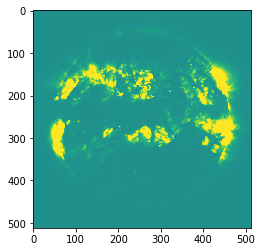

In [9]:
plt.imshow(pred_cov, vmin=-1, vmax=1)

In [10]:
gt_cov = cov_channels_on_time(filename_211, filename_211, cov_dates, img='gt_img')

The cov image has shape (512, 512)


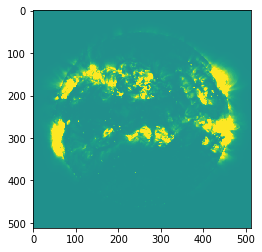

In [11]:
plt.imshow(gt_cov, vmin=-1, vmax=1)

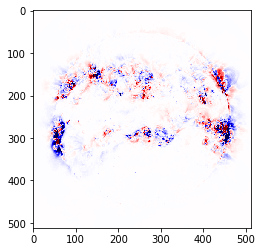

In [12]:
plt.imshow(pred_cov - gt_cov, vmin=-1, vmax=1, cmap='seismic')

# Covariance between channels on Valentine's Day Flare

In [13]:
flare_date = [2011, 2, 15, 1, 50]

In [14]:
# February is a month on which we train, let's check if we trained on this timestamp
train_filename_211 = results_path + '0600_vale_exp_20_train_predictions_timestamps.npz'

In [15]:
train_timestamps = list_dates(train_filename_211)
flare_dates = [date for date in train_timestamps if 2011 in date]
flare_dates = [date for date in flare_dates if (date[1]==2 and date[2]==15)]

In [16]:
# good news is that we didn't train at the time of the flare
flare_dates

[array([2011,    2,   15,    0,    0]),
 array([2011,    2,   15,   12,    0]),
 array([2011,    2,   15,   18,    0]),
 array([2011,    2,   15,    6,    0])]

In [17]:
# We want to load data at available time closest to [2011, 2, 15, 1, 50] and 1h30 before and 1h30 after
# This cell will take a couple of minutes to run
# NB. very unconvenient that we have to load all the year and we can't pass a range ... we should change this
data = VirtualTelescopeSDO_Dataset(data_basedir='/fdl_sdo_data/SDOMLmm/fdl_sw/SDOMLmm', 
    data_inventory='/home/Valentina/inventory_1904.pkl', 
    instr=["AIA", "AIA", "AIA", "AIA"], 
    num_channels = 4,
    channels=["0094", "0193", "0171", "0211"],
    yr_range=[2011, 2011],
    mnt_step=1,
    day_step=1,
    h_step=1,
    min_step=1,
    resolution=512,
    subsample=1,
    test=False,
    test_ratio=0.0,
    shuffle=False,
    normalization=0,
    scaling=True,
    apodize=False,
    holdout=False)

In [18]:
# select indexes that correspond to the desired timestamps
# with the above configuration the times at 15/45 are not found
sel_timestamps = [
    [2011,    2,   15,    0,    0],
    #[2011,    2,   15,    0,    15],
    [2011,    2,   15,    0,    30],
    #[2011,    2,   15,    0,    45],
    [2011,    2,   15,   1,    0],
    #[2011,    2,   15,   1,    15],
    [2011,    2,   15,   1,    30],
    #[2011,    2,   15,   1,    45],
    [2011,    2,   15,   2,    0],
    #[2011,    2,   15,   2,    15],
    [2011,    2,   15,   2,    30],
    #[2011,    2,   15,   2,    45],
    [2011,    2,   15,   3,    0]
]
# the step below takes some time and it is deterministic, this is way we saved the indexes below

# sel_index = []
# for idx, (_, _,timestamp) in enumerate(data):
#    if timestamp.numpy().tolist() in sel_timestamps:
#        sel_index.append(idx)

# 10557 tensor([2011,    2,   15,    0,    0])
# 10562 tensor([2011,    2,   15,    0,   30])
# 10567 tensor([2011,    2,   15,    1,    0])
# 10572 tensor([2011,    2,   15,    1,   30])
# 10577 tensor([2011,    2,   15,    2,    0])
# 10582 tensor([2011,    2,   15,    2,   30])
# 10587 tensor([2011,    2,   15,    3,    0])
sel_index_30 = [10557, 10562, 10567, 10572, 10577, 10582, 10587]

In [19]:
for idx in sel_index_30:
    print(idx, data[idx][2])

10557 tensor([2011,    2,   15,    0,    0])
10562 tensor([2011,    2,   15,    0,   30])
10567 tensor([2011,    2,   15,    1,    0])
10572 tensor([2011,    2,   15,    1,   30])
10577 tensor([2011,    2,   15,    2,    0])
10582 tensor([2011,    2,   15,    2,   30])
10587 tensor([2011,    2,   15,    3,    0])


In [20]:
# we collect the data for the analysis
input_data = []
gt_img = []
timestamps = []
for idx in sel_index_30:
    input_data.append(data[idx][0])
    gt_img.append(data[idx][1])
    timestamps.append(data[idx][2])

In [21]:
# load the trained model for inference (it takes a couple of mins)
results_path = '/fdl_sdo_data/bucket/EXPERIMENT_RESULTS/VIRTUAL_TELESCOPE/vale_exp_20/'
model_path = results_path + '0600_vale_exp_20_model.pth'
model = VT_UnetGenerator(input_shape=[3, 512, 512])
state_dict = torch.load(model_path)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") 
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.eval();

In [22]:
input_data[0].numpy().shape

(3, 512, 512)

In [23]:
# compute the virtual image for each timestamp (this will take several minutes)
outputs = []
for i, idx in enumerate(sel_index_30):
    print(data[idx][2])
    outputs.append(
        model(data[idx][0].unsqueeze(0)).detach().numpy().reshape(1, 512, 512)
    )

tensor([2011,    2,   15,    0,    0])
tensor([2011,    2,   15,    0,   30])
tensor([2011,    2,   15,    1,    0])
tensor([2011,    2,   15,    1,   30])
tensor([2011,    2,   15,    2,    0])
tensor([2011,    2,   15,    2,   30])
tensor([2011,    2,   15,    3,    0])


# Looking at diference in covariance at interval of 30mins

In [149]:
results = pd.DataFrame()
for i, idx in enumerate(sel_index_30):
    ts = '-'.join([str(i.item()) for i in timestamps[i]])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    for j, ch in enumerate(["094", "193", "171"]):
        cov_orig, cov_synth = 0, 0
        Y = input_data[i][j].detach().numpy().reshape(512, 512)
        cov_orig = cov_1d(X_orig,Y)
        cov_synth = cov_1d(X_s,Y)
        results = results.append(
            pd.DataFrame(index=[i], data={'Timestamp': ts, 'Channel': ch, 
                               'True Cov': cov_orig, 'Pred Cov': cov_synth, 
                               'Diff': (cov_orig - cov_synth), 
                               '%Diff': (cov_orig - cov_synth)*100/cov_orig})
        )

In [150]:
results.reset_index().drop('index', axis=1).style.background_gradient(cmap='YlOrRd')

,Timestamp,Channel,True Cov,Pred Cov,Diff,%Diff
0,2011-2-15-0-0,094,0.278182,0.256109,0.022072,7.9344
1,2011-2-15-0-0,193,0.0477639,0.0470902,0.000673658,1.41039
2,2011-2-15-0-0,171,0.117358,0.114861,0.00249642,2.12719
3,2011-2-15-0-30,094,0.182729,0.18069,0.00203837,1.11552
4,2011-2-15-0-30,193,0.0488993,0.0487584,0.000140891,0.288125
5,2011-2-15-0-30,171,0.115963,0.114932,0.00103137,0.889399
6,2011-2-15-1-0,094,0.261833,0.246267,0.0155654,5.94478
7,2011-2-15-1-0,193,0.0474942,0.0468872,0.000606919,1.27788
8,2011-2-15-1-0,171,0.11442,0.112209,0.00221157,1.93285
9,2011-2-15-1-30,094,0.187012,0.185191,0.00182097,0.973719


* As expected results are very different for 193/171 and 094, being in general much worse for 094
* Difference between real and predicted covariance >1h before the flare is ~1%, but can arrive up to 6% in 094
* After and close to the flare the predicted covariance is completely off and systematically larger

# Comparing maps using a Neighborhood covariance with rolling average window

tensor([2011,    2,   15,    0,    0])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


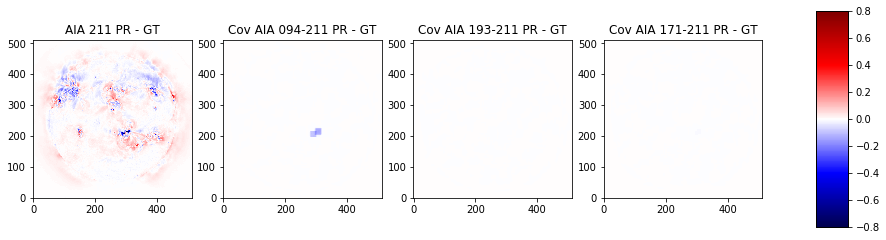

tensor([2011,    2,   15,    0,   30])


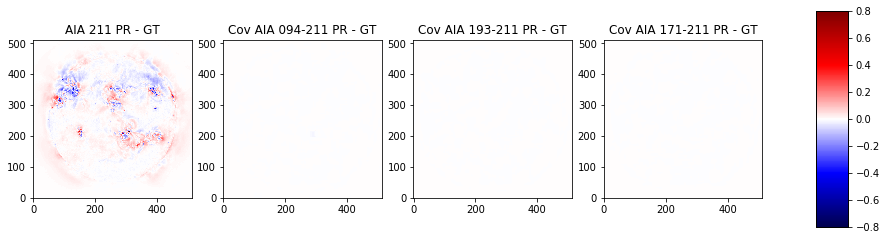

tensor([2011,    2,   15,    1,    0])


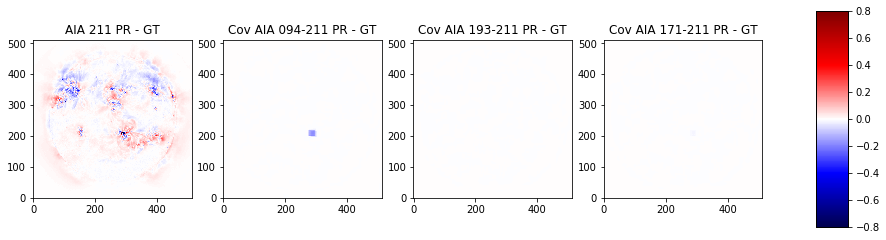

tensor([2011,    2,   15,    1,   30])


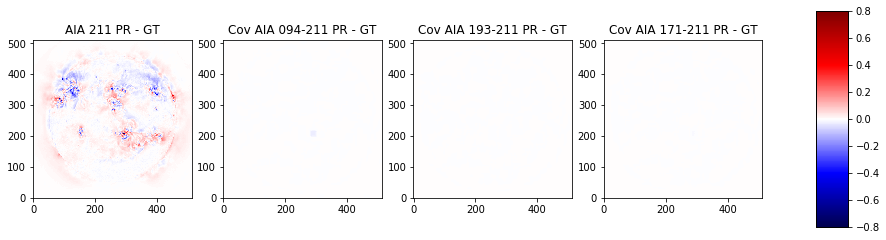

tensor([2011,    2,   15,    2,    0])


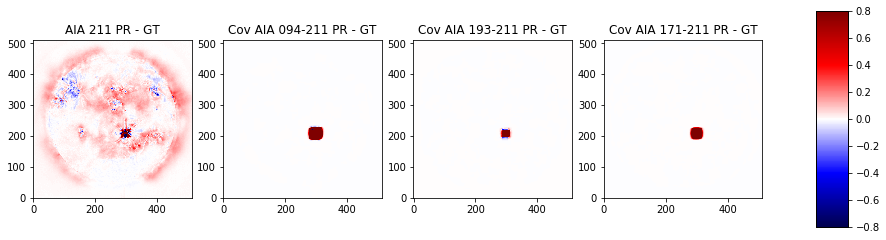

tensor([2011,    2,   15,    2,   30])


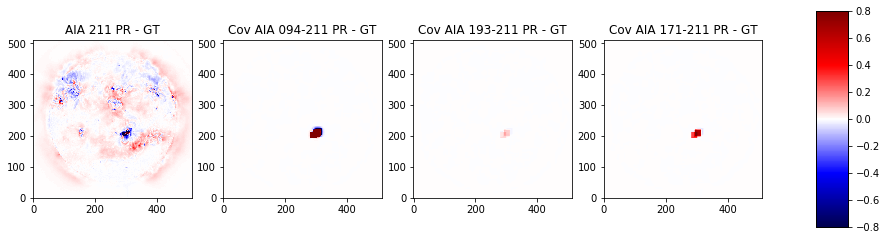

tensor([2011,    2,   15,    3,    0])


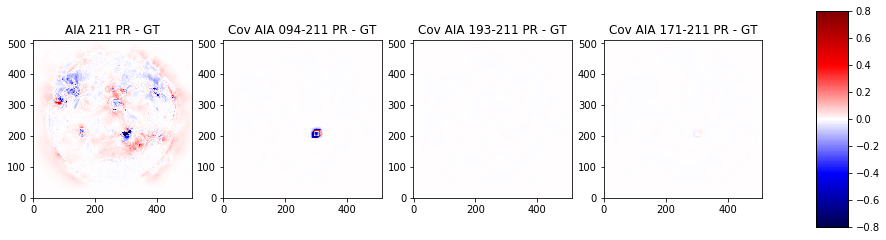

In [146]:
# compute covariance with real and synthetic image
for i, idx in enumerate(sel_index_30):
    fig, axs = plt.subplots(1,4, figsize=(15, 10))
    print(timestamps[i])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    im = axs[0].set_title(f'AIA 211 PR - GT')
    im = axs[0].imshow((X_s - X_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
    for j, ch in enumerate(["094", "193", "171"]):    
        Y = input_data[i][j].detach().numpy().reshape(512,512)
        cov_synth = neighbor_cov(X_s, Y, size=20)
        cov_orig = neighbor_cov(X_orig, Y, size=20)
        im = axs[j+1].set_title(f'Cov AIA {ch}-{211} PR - GT')
        im = axs[j+1].imshow((cov_synth - cov_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
        fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
        fig.colorbar(im, cax=cbar_ax)
    plt.show()

as suggested by the aggregated covariance on the full image, results before and after the flare are much worse, 
particulalry the 094-211 pair. We can however see the error is localised

tensor([2011,    2,   15,    1,   30])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


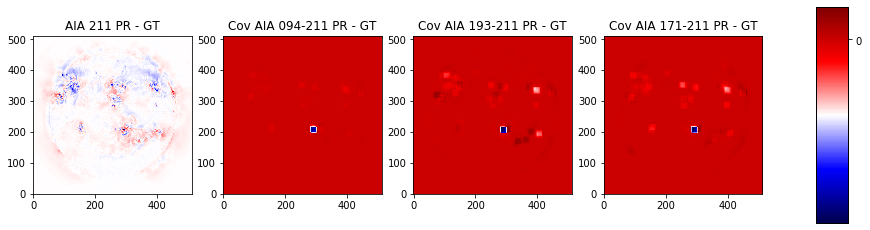

tensor([2011,    2,   15,    2,    0])


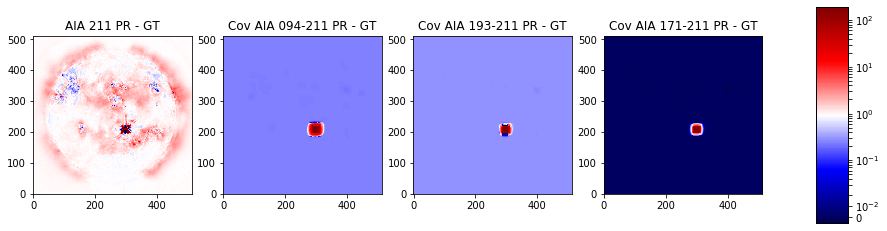

tensor([2011,    2,   15,    2,   30])


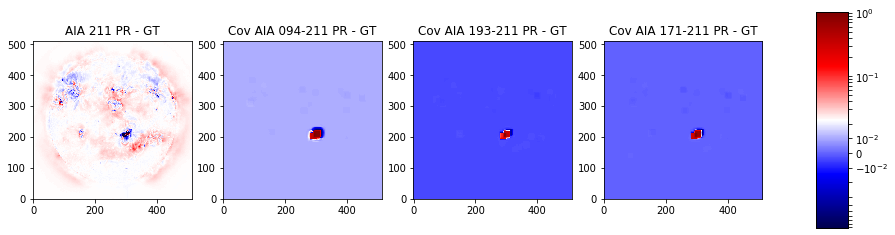

tensor([2011,    2,   15,    3,    0])


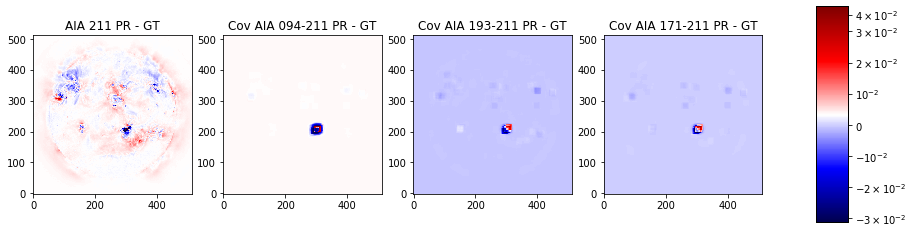

In [147]:
# same as above but with LogNorm, to show what happens close to the flare
for i, idx in enumerate(sel_index_30):
    if i>=3:
        fig, axs = plt.subplots(1,4, figsize=(15, 10))
        print(timestamps[i])
        X_s = outputs[i].reshape(512, 512)
        X_orig = gt_img[i].detach().numpy().reshape(512, 512)
        im = axs[0].set_title(f'AIA 211 PR - GT')
        im = axs[0].imshow((X_s - X_orig), cmap='seismic', origin='lower', vmin=-0.8, vmax=0.8)
        for j, ch in enumerate(["094", "193", "171"]):    
            Y = input_data[i][j].detach().numpy().reshape(512,512)
            cov_synth = neighbor_cov(X_s, Y, size=20)
            cov_orig = neighbor_cov(X_orig, Y, size=20)
            im = axs[j+1].set_title(f'Cov AIA {ch}-{211} PR - GT')
            Z = cov_synth - cov_orig
            im = axs[j+1].imshow(Z, cmap='seismic', origin='lower',
                                norm=mpl.colors.SymLogNorm(linthresh=0.03, vmin=Z.min(), vmax=Z.max()))
            fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
            cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
            fig.colorbar(im, cax=cbar_ax)
        plt.show()

# Compute covariance with real and synthetic image using stacking

tensor([2011,    2,   15,    0,    0])


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


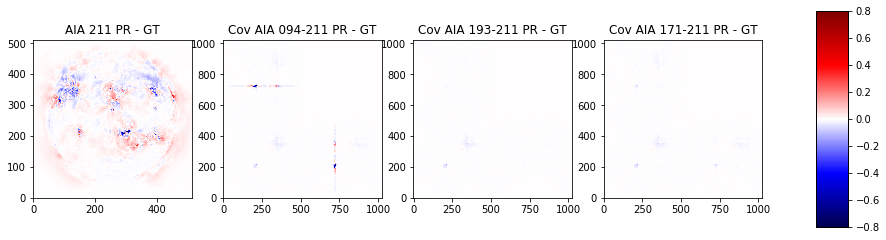

tensor([2011,    2,   15,    0,   30])


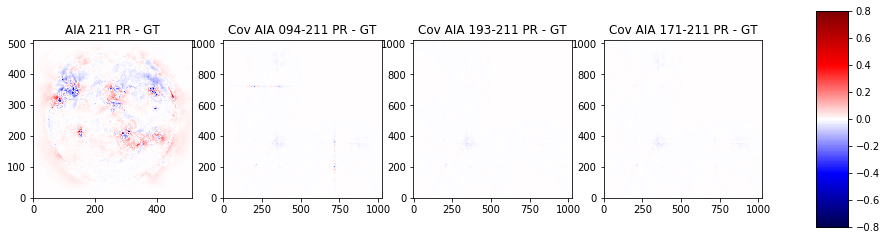

tensor([2011,    2,   15,    1,    0])


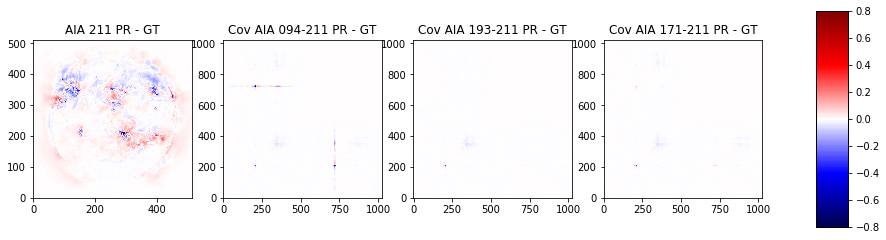

tensor([2011,    2,   15,    1,   30])


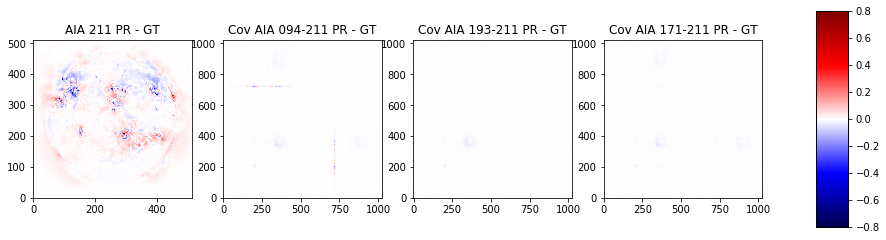

tensor([2011,    2,   15,    2,    0])


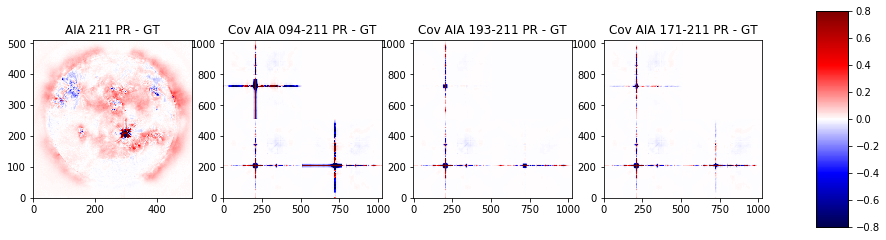

tensor([2011,    2,   15,    2,   30])


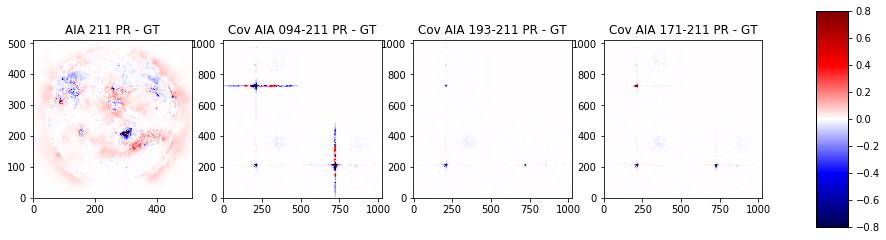

tensor([2011,    2,   15,    3,    0])


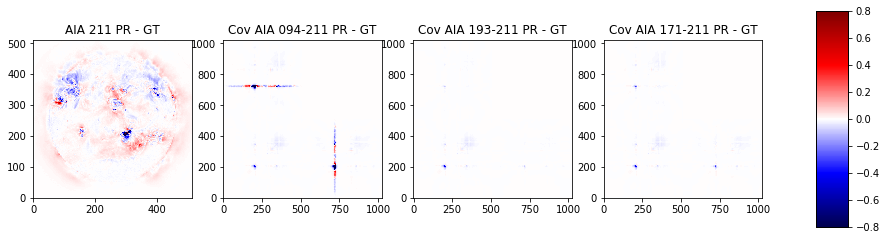

In [57]:
# this seems a pretty common choice when dealing with a 2D image but the np.cov average on the column in this side
# it's not longer possible to spatially interpret the value)
for i, idx in enumerate(sel_index_30):
    fig, axs = plt.subplots(1,4, figsize=(15, 10))
    print(timestamps[i])
    X_s = outputs[i].reshape(512, 512)
    X_orig = gt_img[i].detach().numpy().reshape(512, 512)
    im = axs[0].set_title(f'AIA 211 PR - GT')
    im = axs[0].imshow((X_s - X_orig), cmap='seismic', vmin=-0.8, vmax=0.8,origin='lower')
    for j, ch in enumerate(["094", "193", "171"]):    
        Y = input_data[i][j].detach().numpy().reshape(512, 512)
        z = np.vstack((X_s, Y))
        cov_synth = np.cov(z)
        z = np.vstack((X_orig, Y))
        cov_orig = np.cov(z)
        im = axs[j+1].set_title(f'Cov AIA {ch}-{211} PR - GT')
        im = axs[j+1].imshow((cov_synth - cov_orig), cmap='seismic', vmin=-0.8, vmax=0.8, origin='lower')
        fig.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.3])
        fig.colorbar(im, cax=cbar_ax)
    plt.show()